# Bibliotecas

In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDRegressor, LinearRegression, HuberRegressor, Ridge, RidgeCV, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Funções Auxiliares

In [2]:
def percentual_outlier(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
    num_outliers =  np.sum((data < minimum) | (data > maximum))
    num_total = data.count()
    return (num_outliers/num_total)*100

def plot_history(history):
    mse = history.history['mse']
    val_mse = history.history['val_mse']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(mse) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.ylim(0,6000000000)
    plt.plot(x, mse, 'b', label='Training MSE')
    plt.plot(x, val_mse, 'r', label='Validation MSE')
    plt.title('Training and validation MSE')
    plt.subplot(1, 2, 2)
    plt.ylim(0,100000)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

# Carregando os Dados
## dados pré processados no notebbok de análises de dados

In [4]:
df = pd.read_csv("./df_pre_processado.csv")

In [5]:
df.head(10)

,numero_solicitacao,razaoSocial,nomeFantasia,cnpjSemTraco,maiorAtraso,margemBrutaAcumulada,percentualProtestos,primeiraCompra,prazoMedioRecebimentoVendas,titulosEmAberto,...,periodoDemonstrativoEmMeses,custos,anoFundacao,intervaloFundacao,capitalSocial,restricoes,empresa_MeEppMei,scorePontualidade,limiteEmpresaAnaliseCredito,dataAprovadoNivelAnalista
0,1,James Richardson-Patel,Alexandra Williams,KEBE17609492220843,0,0.252448,0.0,2015-12-10T00:00:00,0,0.00,...,12.0,0.0,2003.0,Acima de 17 anos,90000.0,False,True,1.00000,43200.0,2020-02-03T20:57:33
1,3,Joanna Hudson,Dr. David Rees,GCVQ28531614261293,4,0.624777,0.0,2019-11-27T00:00:00,0,0.00,...,7.0,0.0,2014.0,De 6 a 10 anos,20000.0,False,True,1.00000,4320.0,2020-02-04T16:40:49
2,5,Nigel Lee,Dr. Stanley Duncan,CGQN15826802440348,20,0.454088,0.0,2010-07-13T00:00:00,20,1486.95,...,9.0,40680051.0,2002.0,Acima de 17 anos,75000.0,False,False,1.00000,89000.0,2020-02-04T15:06:28
3,7,Alexander Baker-Wells,Dr. Caroline Ali,PYOL43118620147076,16,0.000000,NaN,2011-03-02T11:27:13,0,0.00,...,12.0,156394112.0,1982.0,Acima de 17 anos,30515674.0,True,False,0.00000,18132588.0,2020-02-05T14:31:22
4,8,Jean Berry,Gregory Gould,NLUX93496216176463,4,0.350175,0.0,2007-07-02T00:00:00,102,208980.00,...,9.0,0.0,2000.0,Acima de 17 anos,120000.0,False,False,1.00000,768233.0,2020-02-05T20:05:40
5,9,Elliot Stephenson,Adrian Graham,LOVL82962402474134,43,0.245818,0.0,2006-07-10T00:00:00,27,6432.00,...,12.0,-49267738.0,2000.0,Acima de 17 anos,1000000.0,False,False,1.00000,6910219.0,2020-02-05T20:07:07
6,10,Dr. Dale Dawson,Caroline Hale,NXKJ36775578171965,24,0.000012,0.0,2011-02-24T00:00:00,0,22733.33,...,12.0,15322217.0,1996.0,Acima de 17 anos,80000.0,False,True,0.83159,635270.0,NaN
7,11,Katie Lawson,Patricia Reynolds,SVXA16230297135119,7,0.000000,NaN,2012-02-24T16:01:26,0,0.00,...,6.0,-3299332.0,2011.0,De 6 a 10 anos,20000.0,False,True,0.00000,81000.0,2020-02-05T15:15:10
8,12,Ellie Turner,Mohamed Welch,ELQK41348591516215,26,0.000000,NaN,2017-12-20T17:03:32,0,0.00,...,12.0,-9455401.0,2009.0,De 11 a 16 anos,600000.0,False,False,0.00000,183509.0,NaN
9,14,Nicole Fry,Lewis Harris,PVQV57475295829119,52,0.000000,NaN,2006-05-01T13:18:05,0,0.00,...,9.0,3366929.0,2003.0,Acima de 17 anos,88000.0,False,True,0.00000,739395.0,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6012 entries, 0 to 6011
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   numero_solicitacao           6012 non-null   int64  
 1   razaoSocial                  6012 non-null   object 
 2   nomeFantasia                 6012 non-null   object 
 3   cnpjSemTraco                 6012 non-null   object 
 4   maiorAtraso                  6012 non-null   int64  
 5   margemBrutaAcumulada         6012 non-null   float64
 6   percentualProtestos          5045 non-null   float64
 7   primeiraCompra               5945 non-null   object 
 8   prazoMedioRecebimentoVendas  6012 non-null   int64  
 9   titulosEmAberto              6012 non-null   float64
 10  valorSolicitado              6012 non-null   float64
 11  status                       6012 non-null   object 
 12  definicaoRisco               6012 non-null   object 
 13  diferencaPercentua

<h3>
Nesta análise vamos usar a variável "valorAprovado" como target para a regressão.<BR>
Portanto vamos trabalhar apenas com os dados que possuem este valor, ou seja, os clientes que tiveram o seu crédito aprovado.<BR>
</h3>

In [7]:
df = df[~(df.valorAprovado.isnull())]

In [ ]:
df.fillna(value={'custos': 43925049.88, 'faturamentoBruto': 81954930.29, 'margemBruta': 25636419.82, 'periodoDemonstrativoEmMeses': 10.62}, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5095 entries, 0 to 5094
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   numero_solicitacao           5095 non-null   int64  
 1   razaoSocial                  5095 non-null   object 
 2   nomeFantasia                 5095 non-null   object 
 3   cnpjSemTraco                 5095 non-null   object 
 4   maiorAtraso                  5095 non-null   int64  
 5   margemBrutaAcumulada         5095 non-null   float64
 6   percentualProtestos          4300 non-null   float64
 7   primeiraCompra               5061 non-null   object 
 8   prazoMedioRecebimentoVendas  5095 non-null   int64  
 9   titulosEmAberto              5095 non-null   float64
 10  valorSolicitado              5095 non-null   float64
 11  status                       5095 non-null   object 
 12  definicaoRisco               5095 non-null   object 
 13  diferencaPercentua

In [77]:
df_num = df.drop(['cnpjSemTraco', 'percentualProtestos', 'dataAprovadoEmComite', 'dataAprovadoNivelAnalista', 'numero_solicitacao', 'razaoSocial', 'nomeFantasia', 'anoFundacao', 'status', 'definicaoRisco', 'diferencaPercentualRisco', 'dashboardCorrelacao',
         'periodoBalanco', 'primeiraCompra', 'intervaloFundacao', 'periodoDemonstrativoEmMeses', 'restricoes', 'empresa_MeEppMei'], axis=1)

In [36]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5095 entries, 0 to 5094
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   maiorAtraso                  5095 non-null   int64  
 1   margemBrutaAcumulada         5095 non-null   float64
 2   prazoMedioRecebimentoVendas  5095 non-null   int64  
 3   titulosEmAberto              5095 non-null   float64
 4   valorSolicitado              5095 non-null   float64
 5   percentualRisco              5095 non-null   float64
 6   valorAprovado                5095 non-null   float64
 7   ativoCirculante              5095 non-null   float64
 8   passivoCirculante            5095 non-null   float64
 9   totalAtivo                   5095 non-null   float64
 10  totalPatrimonioLiquido       5095 non-null   float64
 11  endividamento                5095 non-null   float64
 12  duplicatasAReceber           5095 non-null   float64
 13  estoque           

In [37]:
df_num.describe()

,maiorAtraso,margemBrutaAcumulada,prazoMedioRecebimentoVendas,titulosEmAberto,valorSolicitado,percentualRisco,valorAprovado,ativoCirculante,passivoCirculante,totalAtivo,totalPatrimonioLiquido,endividamento,duplicatasAReceber,estoque,faturamentoBruto,margemBruta,custos,capitalSocial,scorePontualidade,limiteEmpresaAnaliseCredito
count,5095.000000,5095.000000,5095.000000,5.095000e+03,5.095000e+03,5095.000000,5.095000e+03,5.095000e+03,5.095000e+03,5.095000e+03,5.095000e+03,5.095000e+03,5.095000e+03,5.095000e+03,5.095000e+03,5.095000e+03,5.095000e+03,5.095000e+03,5095.000000,5.095000e+03
mean,27.003729,0.364419,28.295584,8.543531e+04,6.683094e+05,0.241081,2.373725e+05,4.073206e+07,3.122290e+07,6.472294e+07,2.597326e+07,4.289277e+06,1.520065e+07,1.382626e+07,8.195493e+07,2.563642e+07,4.392505e+07,1.028468e+07,0.808914,3.318825e+06
std,65.864579,0.195034,80.141780,2.538122e+05,1.891528e+07,0.121311,5.230164e+05,4.502796e+08,4.766934e+08,8.550043e+08,2.479736e+08,3.612967e+07,2.870737e+08,8.024700e+07,4.170462e+08,1.461046e+08,2.582225e+08,9.097308e+07,0.368151,3.192249e+07
min,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+02,0.000000,0.000000e+00,-1.700000e+01,-3.555090e+05,-1.700000e+01,-1.867197e+08,0.000000e+00,-2.278071e+07,-2.632260e+05,0.000000e+00,-6.148721e+08,-3.466338e+08,0.000000e+00,0.000000,0.000000e+00
25%,3.000000,0.291822,0.000000,0.000000e+00,4.000000e+04,0.142857,2.500000e+04,6.308945e+05,1.205435e+05,7.795880e+05,1.434470e+05,0.000000e+00,1.653000e+03,1.120940e+05,2.124384e+06,0.000000e+00,0.000000e+00,9.540000e+04,0.893769,1.184000e+04
50%,8.000000,0.405087,0.000000,2.918750e+03,7.000000e+04,0.232143,5.000000e+04,3.319814e+06,1.155866e+06,3.954907e+06,1.384159e+06,0.000000e+00,9.179290e+05,9.233710e+05,6.941291e+06,1.907123e+06,2.330486e+06,2.000000e+05,1.000000,8.910000e+04
75%,25.000000,0.503999,37.000000,3.994417e+04,2.375000e+05,0.321429,1.900000e+05,1.424620e+07,6.548251e+06,1.758751e+07,7.283365e+06,6.216420e+05,5.462413e+06,4.710116e+06,2.827401e+07,8.706096e+06,1.389137e+07,8.000000e+05,1.000000,7.594370e+05
max,977.000000,1.000000,1605.000000,2.836656e+06,1.200000e+09,0.735849,6.550000e+06,2.903832e+10,2.750382e+10,5.482350e+10,1.292328e+10,7.406315e+08,2.009358e+10,1.293428e+09,6.426115e+09,3.366843e+09,4.393536e+09,4.100000e+09,1.000000,1.974261e+09


<AxesSubplot:>

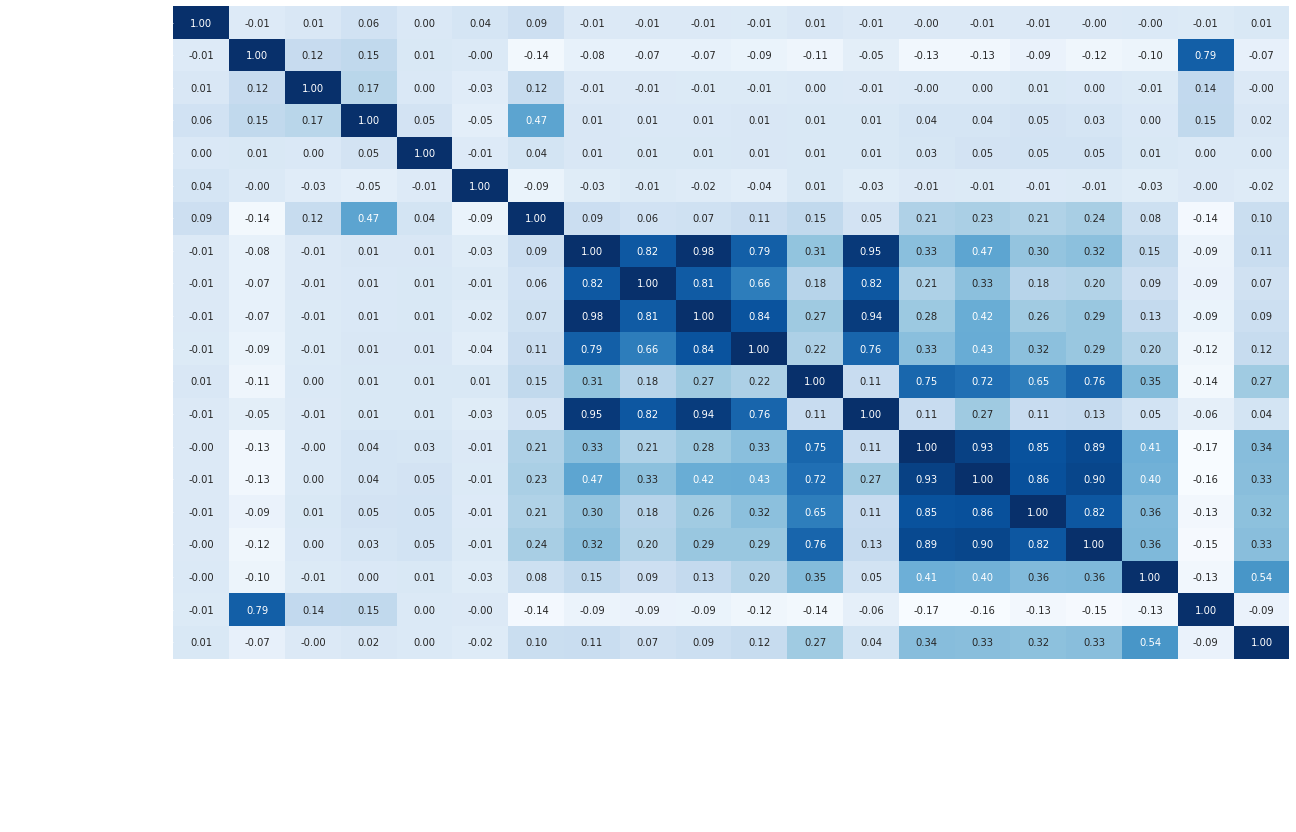

In [38]:
fig = plt.figure(figsize=(20,12))
sns.heatmap(df_num.corr(), cmap='Blues', annot=True, cbar=False, fmt='0.2f')

In [78]:
df_num.drop(['ativoCirculante', 'scorePontualidade', 'estoque'], axis=1, inplace=True)

<AxesSubplot:>

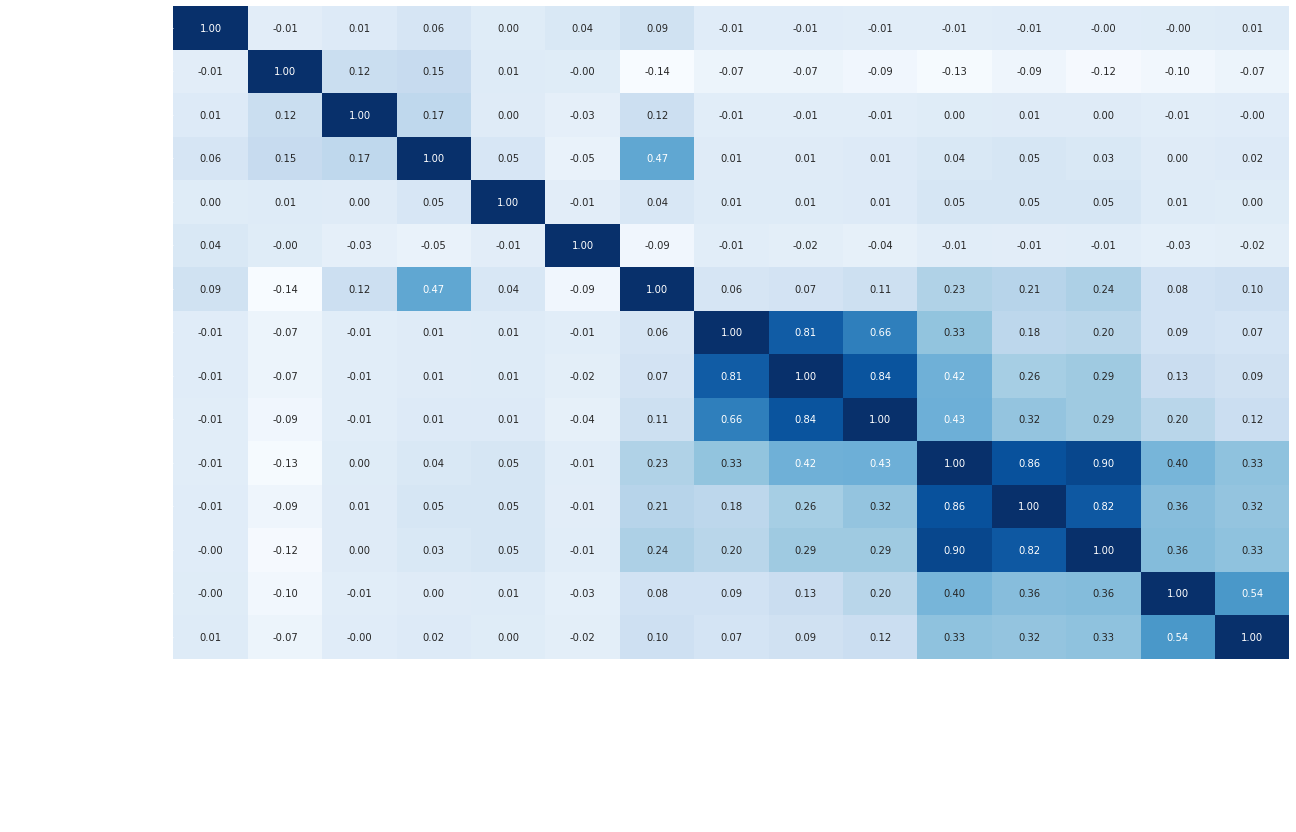

In [60]:
fig = plt.figure(figsize=(20,12))
sns.heatmap(df_num.corr(), cmap='Blues', annot=True, cbar=False, fmt='0.2f')

In [79]:
for coluna in df_num.columns:
    data = df_num[coluna]
    perc = str(round(percentual_outlier(data), 2))
    print(f'Outliers na coluna {coluna} : {perc}%')

Outliers na coluna maiorAtraso : 11.27%
Outliers na coluna margemBrutaAcumulada : 0.12%
Outliers na coluna prazoMedioRecebimentoVendas : 5.99%
Outliers na coluna titulosEmAberto : 16.13%
Outliers na coluna valorSolicitado : 12.44%
Outliers na coluna percentualRisco : 0.47%
Outliers na coluna valorAprovado : 13.09%
Outliers na coluna passivoCirculante : 14.45%
Outliers na coluna totalAtivo : 13.29%
Outliers na coluna totalPatrimonioLiquido : 13.82%
Outliers na coluna endividamento : 17.98%
Outliers na coluna duplicatasAReceber : 12.86%
Outliers na coluna faturamentoBruto : 13.37%
Outliers na coluna margemBruta : 13.31%
Outliers na coluna custos : 13.6%
Outliers na coluna capitalSocial : 14.66%
Outliers na coluna limiteEmpresaAnaliseCredito : 16.7%


In [80]:
for column in df_num.columns:
    data = df_num[column]
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
 
    outliers = ((data < minimum) | (data > maximum))
    df_num[column].loc[outliers] = np.nan
    
df_num.dropna(inplace=True)    

In [81]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2635 entries, 0 to 5093
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   maiorAtraso                  2635 non-null   float64
 1   margemBrutaAcumulada         2635 non-null   float64
 2   prazoMedioRecebimentoVendas  2635 non-null   float64
 3   titulosEmAberto              2635 non-null   float64
 4   valorSolicitado              2635 non-null   float64
 5   percentualRisco              2635 non-null   float64
 6   valorAprovado                2635 non-null   float64
 7   passivoCirculante            2635 non-null   float64
 8   totalAtivo                   2635 non-null   float64
 9   totalPatrimonioLiquido       2635 non-null   float64
 10  endividamento                2635 non-null   float64
 11  duplicatasAReceber           2635 non-null   float64
 12  faturamentoBruto             2635 non-null   float64
 13  margemBruta       

In [82]:
df_num.describe()

,maiorAtraso,margemBrutaAcumulada,prazoMedioRecebimentoVendas,titulosEmAberto,valorSolicitado,percentualRisco,valorAprovado,passivoCirculante,totalAtivo,totalPatrimonioLiquido,endividamento,duplicatasAReceber,faturamentoBruto,margemBruta,custos,capitalSocial,limiteEmpresaAnaliseCredito
count,2635.000000,2635.000000,2635.000000,2635.000000,2635.000000,2635.000000,2635.000000,2.635000e+03,2.635000e+03,2.635000e+03,2.635000e+03,2.635000e+03,2.635000e+03,2.635000e+03,2.635000e+03,2.635000e+03,2.635000e+03
mean,10.718027,0.363701,12.518406,10034.462478,72628.769639,0.257452,52962.514611,9.087844e+05,2.759368e+06,1.517572e+06,1.026772e+05,9.141844e+05,5.580849e+06,1.629595e+06,2.164636e+06,2.186344e+05,1.478921e+05
std,12.794644,0.187023,20.458208,18583.891358,74970.161237,0.125454,58161.454668,1.617199e+06,3.800124e+06,2.510455e+06,2.417739e+05,1.714869e+06,7.735030e+06,2.658607e+06,3.875131e+06,2.895161e+05,2.929141e+05
min,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,1.000000,-3.555090e+05,-1.700000e+01,-2.075497e+06,0.000000e+00,0.000000e+00,0.000000e+00,-2.846171e+06,-7.036474e+06,0.000000e+00,0.000000e+00
25%,3.000000,0.295783,0.000000,0.000000,30000.000000,0.150943,17000.000000,1.002000e+03,8.344300e+04,0.000000e+00,0.000000e+00,0.000000e+00,1.228821e+06,0.000000e+00,0.000000e+00,6.000000e+04,7.360000e+03
50%,5.000000,0.403028,0.000000,0.000000,50000.000000,0.250000,35000.000000,2.815460e+05,1.310153e+06,4.881440e+05,0.000000e+00,1.678460e+05,3.059476e+06,6.164600e+05,6.231230e+05,1.000000e+05,3.520000e+04
75%,17.000000,0.489356,23.000000,12336.670000,90000.000000,0.357143,60000.000000,1.044354e+06,3.623677e+06,1.829478e+06,5.774600e+04,1.056353e+06,6.620958e+06,2.051716e+06,2.596832e+06,2.500000e+05,1.221000e+05
max,58.000000,0.745984,90.000000,97342.260000,500000.000000,0.589286,420000.000000,1.527940e+07,3.060126e+07,1.753293e+07,1.551513e+06,1.264792e+07,6.120184e+07,2.011887e+07,3.315277e+07,1.800000e+06,1.870334e+06


In [83]:
x = df_num.drop('valorAprovado', axis=1)
y = df_num.valorAprovado

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [84]:
lm = LinearRegression()
linear = lm.fit(x_train, y_train)
y_pred = lm.predict(x_test)
print(f"R2 score do treino: {linear.score(x_train, y_train)}")
print(f"R2 score do teste: {linear.score(x_test, y_test)}")

R2 score do treino: 0.7693695913556371
R2 score do teste: 0.6788670408090888


In [85]:
print(mean_absolute_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))
print(mean_squared_error(y_test, y_pred))
print(explained_variance_score(y_test, y_pred))


18102.50489130481
31295.81695219177
979428158.7050939
0.6794199460235029


In [86]:
ridge = Ridge()
lin_rdg = ridge.fit(x_train, y_train)
lin_rdg.score(x_test, y_test)

0.6788526199519223

In [87]:
elastic = ElasticNet()
lin_elastic = elastic.fit(x_train, y_train)
lin_elastic.score(x_test, y_test)

0.6761521645784239

In [88]:
ssc = StandardScaler()
x_ssc = ssc.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_ssc, y, test_size=0.2, random_state=42)

In [89]:
model = Sequential()
model.add(Dense(128, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))

In [95]:
checkpointer = ModelCheckpoint(filepath='./modelo_mlp_ex3.hdf5', verbose=1, save_best_only=True, monitor='val_mae')

model.compile(loss='mae', optimizer='adam', metrics=['mse', 'mae'])
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), callbacks=[checkpointer])

Epoch 1/100
66/66 [==============================] - 1s 4ms/step - loss: 13615.5264 - mse: 585568768.0000 - mae: 13615.5264 - val_loss: 10335.2617 - val_mse: 342889856.0000 - val_mae: 10335.2617

Epoch 00001: val_mae improved from inf to 10335.26172, saving model to .\modelo_mlp_ex3.hdf5
Epoch 2/100
66/66 [==============================] - 0s 3ms/step - loss: 13345.4189 - mse: 575375936.0000 - mae: 13345.4189 - val_loss: 10823.5869 - val_mse: 350187072.0000 - val_mae: 10823.5869

Epoch 00002: val_mae did not improve from 10335.26172
Epoch 3/100
66/66 [==============================] - 0s 3ms/step - loss: 13640.2500 - mse: 592697152.0000 - mae: 13640.2500 - val_loss: 9993.5303 - val_mse: 355202016.0000 - val_mae: 9993.5303

Epoch 00003: val_mae improved from 10335.26172 to 9993.53027, saving model to .\modelo_mlp_ex3.hdf5
Epoch 4/100
66/66 [==============================] - 0s 3ms/step - loss: 13690.0986 - mse: 579661760.0000 - mae: 13690.0986 - val_loss: 10369.4229 - val_mse: 337852768

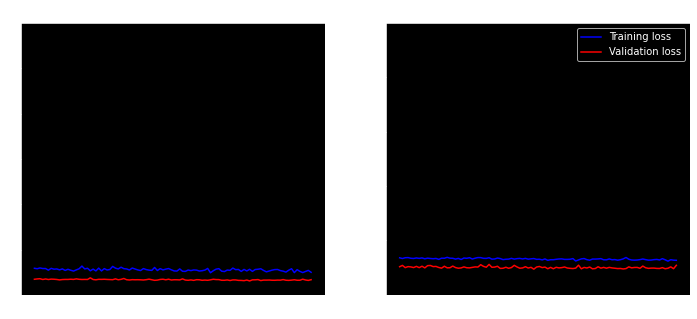

In [96]:
plot_history(history)

In [97]:
model = load_model("./modelo_mlp_ex3.hdf5")

In [98]:
y_pred = model.predict(x_test)
y_p_train = model.predict(x_train)

In [99]:
print(mean_absolute_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))
print(mean_squared_error(y_test, y_pred))
print(explained_variance_score(y_test, y_pred))
print(r2_score(y_train, y_p_train))
print(r2_score(y_test, y_pred))


9430.547923831831
18550.518976029554
344121754.28003263
0.8950838355190082
0.8872206779368667
0.893781944703514
